<a href="https://colab.research.google.com/github/vsgyou/recommendation/blob/main/CVIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CVIB Scratch**
참고([Github](https://github.com/RyanWangZf/CVIB-Rec.git))

In [11]:

import numpy as np
import torch
import os
import pdb
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import defaultdict
np.random.seed(2020)
torch.manual_seed(2020)

mse_func = lambda x,y:np.mean((x-y)**2)
acc_func = lambda x,y:np.sum(x == y) / len(x)

In [ ]:
# Load data
train_file = os.path.join("/content/train.ascii")
test_file = os.path.join("/content/test.ascii")

In [2]:
with open(train_file, "r") as f:
  train_data = []
  for line in f.readlines():
    train_data.append(line.split())
  train_data = np.array(train_data).astype(int)

with open(test_file, "r") as f:
  test_data = []
  for line in f.readlines():
    test_data.append(line.split())
  test_data = np.array(test_data).astype(int)

print("[train_data_sparsity] rating ratio: {:.6f}".format((train_data>0).sum() / (train_data.shape[0] * train_data.shape[1])))
print("[test_data_sparsity]  rating ratio: {:.6f}".format((test_data>0).sum() / (test_data.shape[0] * test_data.shape[1])))

[train_data_sparsity] rating ratio: 0.080000
[test_data_sparsity]  rating ratio: 0.053333


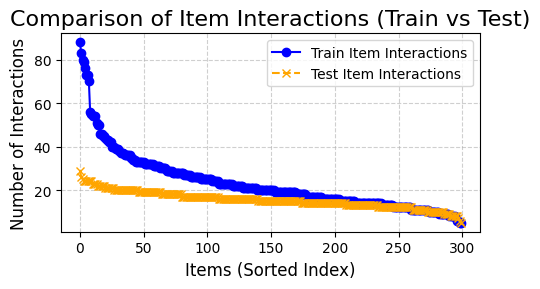

In [31]:
# Distribution of Item interaction
binary_train_data = (train_data > 0).astype(int)
binary_test_data = (test_data>0).astype(int)
train_item_interacions = np.sum(binary_train_data, axis = 0)
test_item_interactions = np.sum(binary_test_data, axis=0)
# binary_train_data = (train_data ).astype(int)
# binary_test_data = (test_data).astype(int)
# train_item_interacions = np.sum(binary_train_data, axis = 0)
# test_item_interactions = np.sum(binary_test_data, axis=0)

import matplotlib.pyplot as plt

train_item_interactions_sort = np.sort(train_item_interacions)[::-1]
test_item_interatctions_sort = np.sort(test_item_interactions)[::-1]

# 그래프 그리기
plt.figure(figsize=(5, 3))

# Train 데이터 그래프 추가
plt.plot(train_item_interactions_sort, label='Train Item Interactions', color='blue', linestyle='-', marker='o')

# Test 데이터 그래프 추가
plt.plot(test_item_interatctions_sort, label='Test Item Interactions', color='orange', linestyle='--', marker='x')

# 그래프 제목 및 레이블
plt.title('Comparison of Item Interactions (Train vs Test)', fontsize=16)
plt.xlabel('Items (Sorted Index)', fontsize=12)
plt.ylabel('Number of Interactions', fontsize=12)

# 범례 추가
plt.legend()

# 격자 추가
plt.grid(True, linestyle='--', alpha=0.6)

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()

Train data에서는 특정 아이템에 편향된 상호작용이 보임

In [50]:
row, col = np.nonzero(train_data)
y = train_data[row,col]
x = np.concatenate([row.reshape(-1,1),col.reshape(-1,1)], axis=1)


array([2, 2, 3, ..., 2, 1, 1])

In [48]:
# rating_mat_to_sample: 데이터를 일반적인 상호작용 데이터 형태로 바꿔줌. x=[user_id, Item_id], y=[평점]
def rating_mat_to_sample(mat):
  row, col = np.nonzero(mat)
  y = mat[row, col]
  x = np.concatenate([row.reshape(-1,1), col.reshape(-1,1)], axis = 1)
  return x,y

# y값 이진화, 평점이 3 이상인 것만 호감으로 표시
def binarize(y, thres = 3):
  y[y< thres] = 0
  y[y>=thres] = 1
  return y


def generate_total_sample(num_user, num_item):
  sample = []
  for i in range(num_user):
    sample.extend([[i,j] for j in range(num_item)])
  return np.array(sample)

def gini_index(user_utility):
    from sklearn.metrics import auc
    cum_L = np.cumsum(np.sort(user_utility))
    sum_L = np.sum(user_utility)
    num_user = len(user_utility)
    xx = np.linspace(0,1,num_user + 1)
    yy = np.append([0],cum_L / sum_L)

    gi = (0.5 - auc(xx,yy)) / 0.5
    gu = sum_L / num_user

    print("Num User:", num_user)
    print("Gini index:", gi)
    print("Global utility:", gu)
    return gi, gu

def ndcg_func(model, x_te, y_te, top_k_list = [5, 10]):
    """Evaluate nDCG@K of the trained model on test dataset.
    """
    all_user_idx = np.unique(x_te[:,0])
    all_tr_idx = np.arange(len(x_te))
    result_map = defaultdict(list)

    for uid in all_user_idx:
        u_idx = all_tr_idx[x_te[:,0] == uid]
        x_u = x_te[u_idx]
        y_u = y_te[u_idx]
        pred_u = model.predict(x_u)

        for top_k in top_k_list:
            pred_top_k = np.argsort(-pred_u)[:top_k]
            count = y_u[pred_top_k].sum()

            log2_iplus1 = np.log2(1+np.arange(1,top_k+1))

            dcg_k = y_u[pred_top_k] / log2_iplus1

            best_dcg_k = y_u[np.argsort(-y_u)][:top_k] / log2_iplus1

            if np.sum(best_dcg_k) == 0:
                ndcg_k = 1
            else:
                ndcg_k = np.sum(dcg_k) / np.sum(best_dcg_k)

            result_map["ndcg_{}".format(top_k)].append(ndcg_k)

    return result_map

def get_user_wise_ctr(x_test,y_test,test_pred,top_N=5):
    offset = 0
    user_idxs = np.unique(x_test[:,0])
    user_ctr_list = []
    for user in user_idxs:
        mask = x_test[:,0] == user
        pred_item = np.argsort(-test_pred[mask])[:top_N] + offset
        u_ctr = y_test[pred_item].sum() / pred_item.shape[0]
        user_ctr_list.append(u_ctr)
        offset += mask.sum()

    user_ctr_list = np.array(user_ctr_list)
    return user_ctr_list



In [53]:
x_train, y_train = rating_mat_to_sample(train_data)
x_test, y_test = rating_mat_to_sample(test_data)
num_user = train_data.shape[0]
num_item = train_data.shape[1]
print(f'유저 수:{num_user}, 아이템 수:{num_item}')

유저 수:290, 아이템 수:300


In [54]:
y_train_bi = binarize(y_train)
y_test_bi = binarize(y_test)

In [7]:
class MF_CVIB(nn.Module):
  def __init__(self, num_users, num_items, embedding_k = 4, *args, **kwargs):
    super(MF_CVIB, self).__init__()
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_k = embedding_k
    self.W = torch.nn.Embedding(self.num_users, self.embedding_k)
    self.H = torch.nn.Embedding(self.num_items, self.embedding_k)

    self.sigmoid = torch.nn.Sigmoid()
    self.xent_func = torch.nn.BCELoss()

  def forward(self, x, is_training = False):
    user_idx = torch.LongTensor(x[:,0])
    item_idx = torch.LongTensor(x[:,1])
    U_emb = self.W(user_idx)
    V_emb = self.H(item_idx)

    out = torch.sum(U_emb.mul(V_emb),1)
    if is_training:
      return out, U_emb, V_emb
    else:
      return out

  def fit(self, x, y, num_epoch = 1000,
          batch_size = 128, lr = 0.05,
          lamb = 0, alpha = 0.1, gamma = 0.01,
          tol = 1e-4, verbose = True):
    self.alpha = alpha
    self.gamma = gamma

    optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = lamb)
    last_loss = 1e9

    x_all = generate_total_sample(self.num_users, self.num_items)

    num_sample = len(x)
    total_batch = num_sample // batch_size
    early_stop = 0

    for epoch in tqdm(range(num_epoch)):
      all_idx = np.arange(num_sample)
      np.random.shuffle(all_idx)

      # sampling counterfactuals
      ul_idxs = np.arange(x_all.shape[0])
      np.random.shuffle(ul_idxs)

      epoch_loss = 0
      for idx in range(total_batch):
        selected_idx = all_idx[batch_size*idx:(idx+1)*batch_size]
        sub_x = x[selected_idx]
        sub_y = y[selected_idx]
        sub_y = torch.Tensor(sub_y)

        pred, u_emb, v_emb = self.forward(sub_x, True)
        pred = self.sigmoid(pred)
        xent_loss = self.xent_func(pred, sub_y) # accuracy 학습

        # pair-wise loss
        x_sampled = x_all[ul_idxs[idx*batch_size:(idx+1)*batch_size]]

        pred_ul,_,_ = self.forward(x_sampled, True)
        pred_ul = self.sigmoid(pred_ul)

        logp_hat = pred.log()
        pred_avg = pred.mean()
        pred_ul_avg = pred_ul.mean()

        info_loss = self.alpha * (- pred_avg * pred_ul_avg.log() - (1-pred_avg) * (1-pred_ul_avg).log()) + self.gamma* torch.mean(pred * logp_hat)
        loss = xent_loss + info_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+= xent_loss.detach().numpy()

      relative_loss_div = (last_loss - epoch_loss)/(last_loss + 1e-10)
      if relative_loss_div < tol:
        if early_stop > 5:
          print("[MF-CVIB] epoch:{}, xent:{}".format(epoch, epoch_loss))
          break
        early_stop += 1
      last_loss = epoch_loss

      if epoch % 10 == 0 and verbose:
        print("[MF-CVIB] epoch:{}, xent:{}".format(epoch, epoch_loss))
      if epoch == num_epoch - 1:
        print("[MF-CVIB] Reach preset epochs, it seems does not converge.")
  def predict(self, x):
    pred = self.forward(x)
    pred = self.sigmoid(pred)
    return pred.detach().numpy()

In [8]:
mf_cvib = MF_CVIB(num_user, num_item)
mf_cvib.fit(x_train, y_train, num_epoch = 100, lr = 0.01, batch_size = 128, lamb = 1e-4, alpha = 10.0, gamma = 1e-4, tol = 1e-5, verbose = False)


 30%|███       | 30/100 [00:04<00:09,  7.46it/s]

[MF-CVIB] epoch:30, xent:108.83231353759766


In [9]:
test_pred = mf_cvib.predict(x_test)
mse_mf = mse_func(y_test, test_pred)
auc_mf = roc_auc_score(y_test, test_pred)
ndcg_res = ndcg_func(mf_cvib, x_test, y_test)

print("***"*5 + "[MF-CVIB]" + "***"*5)
print("[MF-CVIB] test mse:", mse_func(y_test, test_pred))
print("[MF-CVIB] test auc:", auc_mf)
print("[MF] ndcg@5:{:.6f}, ndcg@10:{:.6f}".format(
        np.mean(ndcg_res["ndcg_5"]), np.mean(ndcg_res["ndcg_10"])))
user_wise_ctr = get_user_wise_ctr(x_test,y_test,test_pred)
gi,gu = gini_index(user_wise_ctr)
print("***"*5 + "[MF-CVIB]" + "***"*5)

***************[MF-CVIB]***************
[MF-CVIB] test mse: 0.5794287876545295
[MF-CVIB] test auc: 0.7469744633103895
[MF] ndcg@5:0.655306, ndcg@10:0.712245
Num User: 290
Gini index: 0.31512991899429077
Global utility: 0.5372413793103449
***************[MF-CVIB]***************
